In [4]:

"""
GOCAD data tools.
paulbourke.net/dataformats/gocad/gocad.pdf
from https://github.com/elygeo/coseis/blob/main/cst/gocad.py
https://github.com/esys-escript/esys-escript.github.io/blob/master/doc/examples/usersguide/voxet_reader.py
"""
import os
import numpy as np
import pyvista as pv

def header(buff, counter=0, casters=None):
    """
    GOCAD header reader
    """
    if casters is None:
        casters = {
            int: ('pclip', 'field'),
            bool: ('imap', 'ivolmap', 'parts', 'transparency'),
            float: ('contrast', 'low_clip', 'high_clip', 'transparency_min'),
        }
    cast = {}
    for c in casters:
        for k in casters[c]:
            cast[k] = c
    header = {}
    while counter < len(buff):
        line = buff[counter]
        counter += 1
        if '}' in line:
            return header, counter
        k, v = line.split(':')
        k = k.split('*')[-1]
        header[k] = v
        if k in cast:
            f = v.split()
            if len(f) > 1:
                try:
                    header[k] = tuple(cast[k](x) for x in f)
                except ValueError:
                    print('Could not cast %s %s to %s' % (k, v, cast[k]))
            else:
                try:
                    header[k] = cast[k](v)
                except ValueError:
                    print('Could not cast %s %s to %s' % (k, v, cast[k]))
    raise Exception('Error in header')
    return


def voxet(path, load_props=[], alternate='', no_data_value=None, buff=None):
    """
    GOCAD voxet reader
    """
    if buff is None:
        buff = open(path).read()
    if no_data_value in ('nan', 'NaN', 'NAN'):
        no_data_value = float('nan')
    buff = buff.strip().split('\n')
    cast = {}
    casters = {
        int: ('N', 'ESIZE', 'OFFSET', 'SIGNED', 'PAINTED_FLAG_BIT_POS'),
        str: (
            'NAME', 'FILE', 'TYPE', 'ETYPE', 'FORMAT', 'UNIT',
            'ORIGINAL_UNIT'
        ),
        float: (
            'O', 'D', 'U', 'V', 'W', 'MIN', 'MAX', 'NO_DATA_VALUE',
            'SAMPLE_STATS'
        ),
    }
    for c in casters:
        for k in casters[c]:
            cast[k] = c
    voxet = {}
    counter = 0
    while counter < len(buff):
        line = buff[counter].strip()
        counter += 1
        f = line.replace('"', '').split()
        if len(f) == 0 or line.startswith('#'):
            continue
        elif line.startswith('GOCAD Voxet'):
            id_ = f[2]
            axis, prop = {}, {}
        elif f[0] == 'HEADER':
            hdr, counter = header(buff, counter)
        elif len(f) > 1:
            k = f[0].split('_', 1)
            if k[0] == 'AXIS':
                axis[k[1]] = tuple(cast[k[1]](x) for x in f[1:])
            elif f[0] == 'PROPERTY':
                prop[f[1]] = {'PROPERTY': f[2]}
            elif k[0] == 'PROP':
                if len(f) > 3:
                    prop[f[1]][k[1]] = tuple(cast[k[1]](x) for x in f[2:])
                else:
                    prop[f[1]][k[1]] = cast[k[1]](f[2])
        elif f[0] == 'END':
            for p in load_props:
                print(prop)
                p = prop[p]
                n = axis['N']
                print(n)
                f = os.path.join(os.path.dirname(path), p['FILE'] + alternate)
                print(f)
                if os.path.exists(f):
                    print('exists')
                    dtype = '>f%s' % p['ESIZE']
                    data = numpy.fromfile(f, dtype)
                    if no_data_value is not None:
                        data[data == p['NO_DATA_VALUE']] = no_data_value
                    p['DATA'] = data.reshape(n[::-1]).T
            voxet[id_] = {'HEADER': hdr, 'AXIS': axis, 'PROP': prop}
    return voxet


def tsurf(buff):
    """
    GOCAD triangulated surface reader
    """
    buff = buff.strip().split('\n')
    tsurf = []
    counter = 0
    # casters = {
    #     int: ('ATOM', 'PATOM', 'TRGL', 'BORDER', 'BSTONE'),
    #     float: ('VRTX', 'PVRTX'),
    # }
    while counter < len(buff):
        line = buff[counter].strip()
        counter += 1
        f = line.split()
        if len(f) == 0 or line.startswith('#'):
            continue
        elif line.startswith('GOCAD TSurf'):
            meta0, meta, tri, x, t, b, s, a = None, {}, [], [], [], [], [], []
        elif f[0] in ('VRTX', 'PVRTX'):
            x.append([float(f[2]), float(f[3]), float(f[4])])
        elif f[0] in ('ATOM', 'PATOM'):
            i = int(f[2]) - 1
            a.append([len(x), i])
            # x.append(x[i])
            x.append([float('nan'), float('nan'), float('nan')])
        elif f[0] == 'TRGL':
            t.append([int(f[1]) - 1, int(f[2]) - 1, int(f[3]) - 1])
        elif f[0] == 'BORDER':
            b.append([int(f[2]) - 1, int(f[3]) - 1])
        elif f[0] == 'BSTONE':
            s.append(int(f[1]) - 1)
        elif f[0] == 'TFACE':
            if t != []:
                tri.append(numpy.array(t, 'i'))
            t = []
        elif f[0] == 'END':
            tri.append(numpy.array(t, 'i'))
            x = numpy.array(x, 'f')
            b = numpy.array(b, 'i')
            s = numpy.array(s, 'i')
            for i, j in a:
                tri[tri == i] = j
                b[b == i] = j
                s[s == i] = j
            data = {'vtx': x, 'tri': tri, 'border': b, 'bstone': s}
            meta.update(meta0)
            tsurf.append([meta, data])
        elif f[0] == 'PROPERTY_CLASS_HEADER':
            meta[f[1]], counter = header(buff, counter)
        elif f[0] == 'HEADER':
            meta0, counter = header(buff, counter)
    return tsurf

In [5]:
#r'J:\McArthur\Id1507107909\DIP012\Digital_Data\REGIONAL_MODEL\GOCAD_OBJECTS\GMcAB_OBJECTS\Voxets (.vo)\SEISMIC_CUBE_DIP_DATA\DIP_DATA_VOXET.vo'

In [6]:
hfile = r'H:\GDP00037\Data\SA_Geophysic_Reference_Model\SGrid\SA_Geophysics_Reference_Model_SGrid.sg'
propfile1 = r'H:\GDP00037\Data\SA_Geophysic_Reference_Model\SGrid\\SA_Geophysics_Reference_Model_SGrid__flags@@'
propfile2 = r'H:\GDP00037\Data\SA_Geophysic_Reference_Model\SGrid\\SA_Geophysics_Reference_Model_SGrid__points@@'


In [8]:
#junk = voxet(hfile)
junk=pv.read(r'J:\ogs-6.4.1-79-g69a2996020-Windows-10.0.19043-python-3.8.2-utils\bin\SA_Geophysics_Reference_Model.vtu')

ERROR:root:Cannot read cell data array "Gravity_Inversion_Constrained" from PointData in piece 0.  The data array in the element may be too short.


In [48]:
junk

{'1': {'HEADER': {'name': ' DIP_DATA_VOXET',
   'smoothed': ' on',
   'use_private_colormaps': ' off',
   'probe_type': ' Sections',
   'size': ' 0 0 0 49 49 49',
   'fence0': ' 3 1 2 0 0 0 49 49 49',
   'nb_fences': ' 1',
   'sections': ' 3 1 0 0 2 0 0 3 0 0',
   'VoxetIntersectionAssociation': ' off',
   'variable': ' Dip',
   'painted': ' off',
   'ascii': ' off'},
  'AXIS': {'NAME': ('axis-1', 'axis-2', 'axis-3'),
   'UNIT': ('unitless', 'unitless', 'unitless'),
   'O': (270217.0, 7923111.8125, -15583.5),
   'U': (382516.0, 0.0, 0.0),
   'V': (0.0, 620896.188, 0.0),
   'W': (0.0, 0.0, 31500.0),
   'MIN': (0.0, 0.0, 0.0),
   'MAX': (1.0, 1.0, 1.0),
   'N': (50, 50, 50),
   'TYPE': ('even', 'even', 'even')},
  'PROP': {'1': {'PROPERTY': 'Dip',
    'ORIGINAL_UNIT': 'unitless',
    'UNIT': 'unitless',
    'NO_DATA_VALUE': -99999.0,
    'SAMPLE_STATS': (480.0, 7.91667, 144.068, 0.0, 70.0),
    'ESIZE': 4,
    'ETYPE': 'IEEE',
    'PAINTED_FLAG_BIT_POS': 6,
    'FORMAT': 'RAW',
    'OFFS

In [61]:
junk = voxet(hfile, load_props=['1'], no_data_value=-99999)

{'1': {'PROPERTY': 'Dip', 'ORIGINAL_UNIT': 'unitless', 'UNIT': 'unitless', 'NO_DATA_VALUE': -99999.0, 'SAMPLE_STATS': (480.0, 7.91667, 144.068, 0.0, 70.0), 'ESIZE': 4, 'ETYPE': 'IEEE', 'PAINTED_FLAG_BIT_POS': 6, 'FORMAT': 'RAW', 'OFFSET': 0, 'FILE': 'DIP_DATA_VOXET_Dip@@'}}
(50, 50, 50)
J:\McArthur\Id1507107909\DIP012\Digital_Data\REGIONAL_MODEL\GOCAD_OBJECTS\GMcAB_OBJECTS\Voxets (.vo)\SEISMIC_CUBE_DIP_DATA\DIP_DATA_VOXET_Dip@@
exists


In [62]:
junk

{'1': {'HEADER': {'name': ' DIP_DATA_VOXET',
   'smoothed': ' on',
   'use_private_colormaps': ' off',
   'probe_type': ' Sections',
   'size': ' 0 0 0 49 49 49',
   'fence0': ' 3 1 2 0 0 0 49 49 49',
   'nb_fences': ' 1',
   'sections': ' 3 1 0 0 2 0 0 3 0 0',
   'VoxetIntersectionAssociation': ' off',
   'variable': ' Dip',
   'painted': ' off',
   'ascii': ' off'},
  'AXIS': {'NAME': ('axis-1', 'axis-2', 'axis-3'),
   'UNIT': ('unitless', 'unitless', 'unitless'),
   'O': (270217.0, 7923111.8125, -15583.5),
   'U': (382516.0, 0.0, 0.0),
   'V': (0.0, 620896.188, 0.0),
   'W': (0.0, 0.0, 31500.0),
   'MIN': (0.0, 0.0, 0.0),
   'MAX': (1.0, 1.0, 1.0),
   'N': (50, 50, 50),
   'TYPE': ('even', 'even', 'even')},
  'PROP': {'1': {'PROPERTY': 'Dip',
    'ORIGINAL_UNIT': 'unitless',
    'UNIT': 'unitless',
    'NO_DATA_VALUE': -99999.0,
    'SAMPLE_STATS': (480.0, 7.91667, 144.068, 0.0, 70.0),
    'ESIZE': 4,
    'ETYPE': 'IEEE',
    'PAINTED_FLAG_BIT_POS': 6,
    'FORMAT': 'RAW',
    'OFFS

In [19]:
for key in junk.keys():
    print(junk[key])

{'HEADER': {'name': ' DIP_DATA_VOXET', 'smoothed': ' on', 'use_private_colormaps': ' off', 'probe_type': ' Sections', 'size': ' 0 0 0 49 49 49', 'fence0': ' 3 1 2 0 0 0 49 49 49', 'nb_fences': ' 1', 'sections': ' 3 1 0 0 2 0 0 3 0 0', 'VoxetIntersectionAssociation': ' off', 'variable': ' Dip', 'painted': ' off', 'ascii': ' off'}, 'AXIS': {'NAME': ('axis-1', 'axis-2', 'axis-3'), 'UNIT': ('unitless', 'unitless', 'unitless'), 'O': (270217.0, 7923111.8125, -15583.5), 'U': (382516.0, 0.0, 0.0), 'V': (0.0, 620896.188, 0.0), 'W': (0.0, 0.0, 31500.0), 'MIN': (0.0, 0.0, 0.0), 'MAX': (1.0, 1.0, 1.0), 'N': (50, 50, 50), 'TYPE': ('even', 'even', 'even')}, 'PROP': {'1': {'PROPERTY': 'Dip', 'ORIGINAL_UNIT': 'unitless', 'UNIT': 'unitless', 'NO_DATA_VALUE': -99999.0, 'SAMPLE_STATS': (480.0, 7.91667, 144.068, 0.0, 70.0), 'ESIZE': 4, 'ETYPE': 'IEEE', 'PAINTED_FLAG_BIT_POS': 6, 'FORMAT': 'RAW', 'OFFSET': 0, 'FILE': 'DIP_DATA_VOXET_Dip@@'}}}


In [63]:
junk['1']['PROP']['1']['DATA'].shape

(50, 50, 50)

In [66]:
import numpy as np
np.unique(junk['1']['PROP']['1']['DATA'])

array([-9.9999e+04,  0.0000e+00,  1.0000e+00,  2.0000e+00,  3.0000e+00,
        4.0000e+00,  5.0000e+00,  6.0000e+00,  8.0000e+00,  1.0000e+01,
        1.4000e+01,  1.5000e+01,  2.0000e+01,  2.6000e+01,  3.0000e+01,
        3.2000e+01,  3.5000e+01,  5.0000e+01,  7.0000e+01], dtype=float32)

<ipython-input-67-a7e86292ca8b>:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cells = np.full((len(points)-1, 3), 2, dtype=np.int)
<ipython-input-67-a7e86292ca8b>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated 

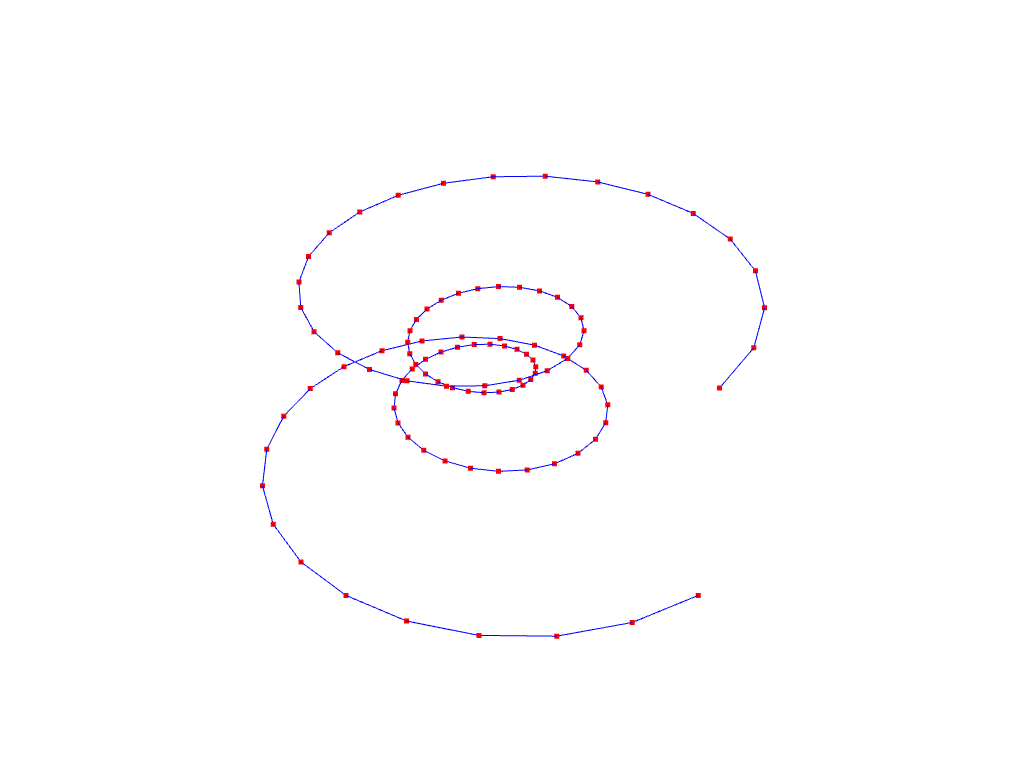

[(13.719394954848525, 14.57901445433668, 13.719394954848525),
 (4.440892098500626e-16, 0.8596194994881534, 0.0),
 (0.0, 0.0, 1.0)]

In [67]:
import pyvista as pv
import numpy as np
pv.set_plot_theme('doc')

def make_points():
    """Helper to make XYZ points"""
    theta = np.linspace(-4 * np.pi, 4 * np.pi, 100)
    z = np.linspace(-2, 2, 100)
    r = z**2 + 1
    x = r * np.sin(theta)
    y = r * np.cos(theta)
    return np.column_stack((x, y, z))


def lines_from_points(points):
    """Given an array of points, make a line set"""
    poly = pv.PolyData()
    poly.points = points
    cells = np.full((len(points)-1, 3), 2, dtype=np.int)
    cells[:, 1] = np.arange(0, len(points)-1, dtype=np.int)
    cells[:, 2] = np.arange(1, len(points), dtype=np.int)
    poly.lines = cells
    return poly

points = make_points()

line = lines_from_points(points)

p = pv.Plotter()
p.add_mesh(points, color='red')
p.add_mesh(line, color='blue',)
p.show()

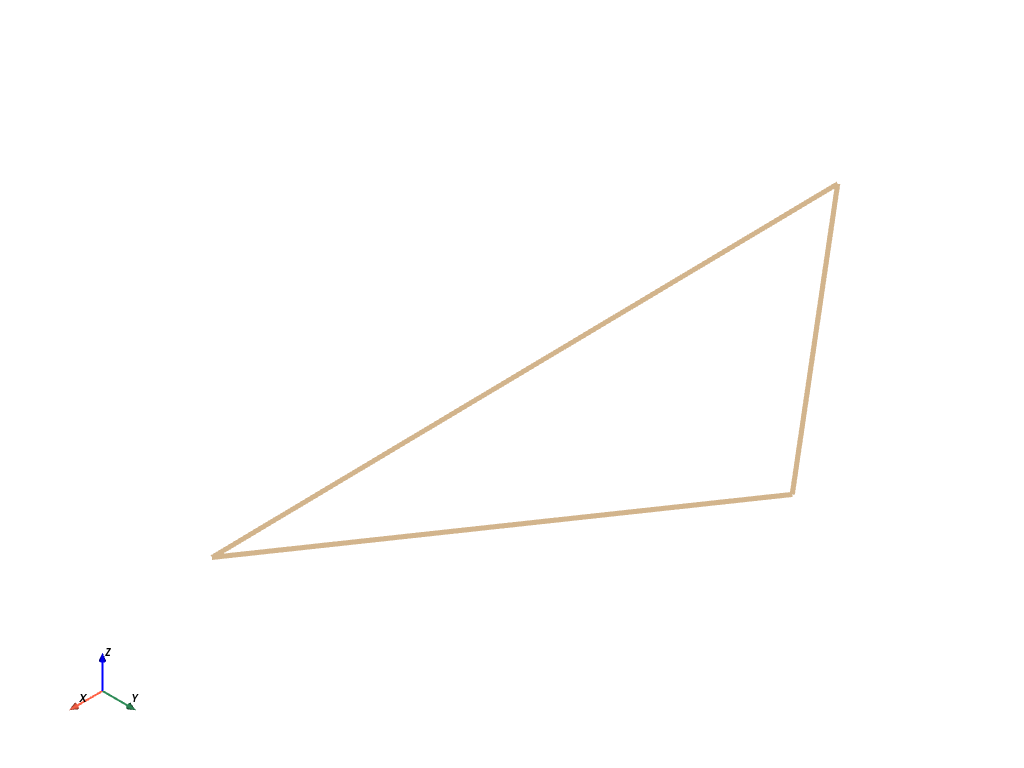

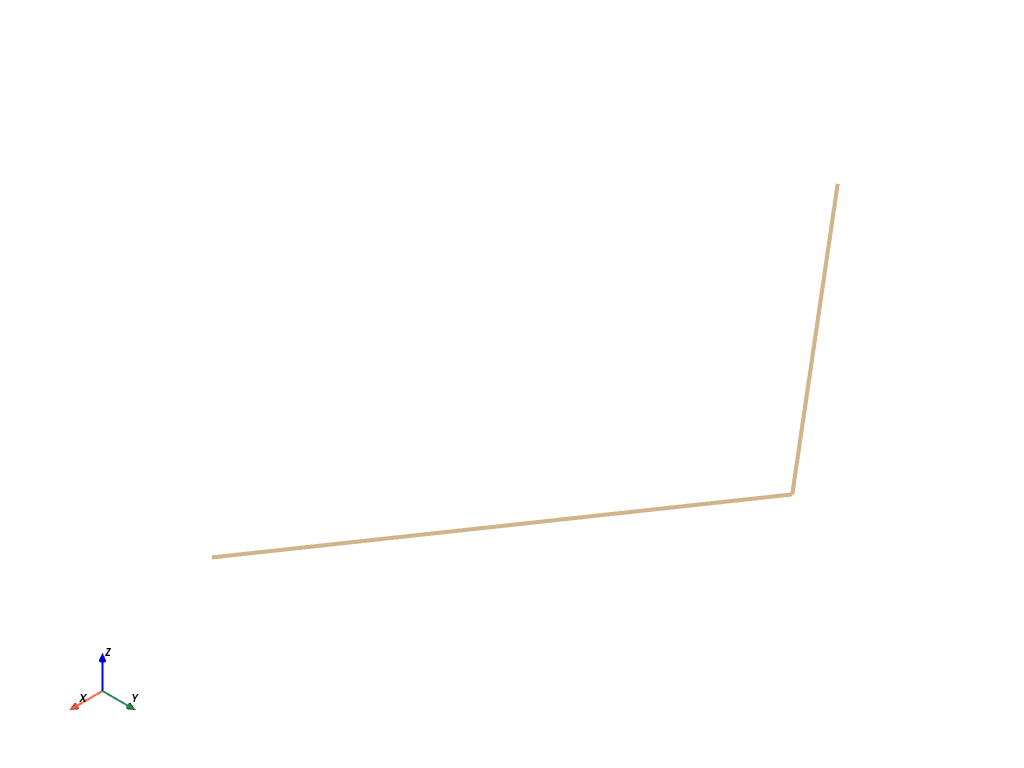

[(630460.6466856378, 8673647.271685638, 78.20070175106548),
 (629812.8125, 8672999.4375, -569.6334838867188),
 (0.0, 0.0, 1.0)]

In [72]:
#https://docs.pyvista.org/api/utilities/_autosummary/pyvista.lines_from_points.html
import numpy as np
import pyvista
points = np.array([[0, 0, 0], [1, 0, 0], [1, 1, 0]])
points = np.array([[629607.40625, 8673138.9375, -419.00299072265625 ], [629607.40625, 8673138.9375, -720.26397705078125 ], [630018.21875, 8672859.9375, -709.30902099609375 ]])
poly = pyvista.lines_from_points(points, close=True)
poly.plot(line_width=5)

poly = pyvista.lines_from_points(points, close=False)
poly.plot(line_width=4)

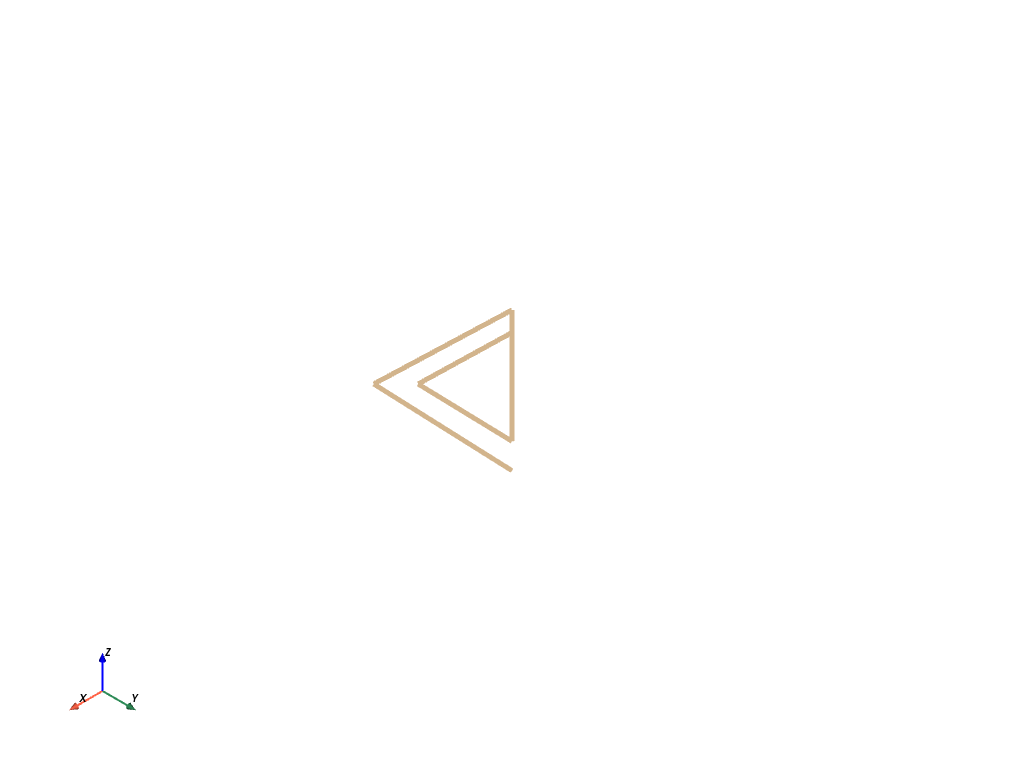

[(6.731479005868078, 6.731479005868078, 6.231479005868078),
 (1.5, 1.5, 1.0),
 (0.0, 0.0, 1.0)]

In [76]:
points = np.array([[0, 0, 0], [1, 0, 0], [1, 1, 0], [2,2, 2], [3, 2, 2], [3, 3, 2]]  )
poly = pyvista.lines_from_points(points)
poly.plot(line_width=5)

In [ ]:
points = np.array([[0, 0, 0],
                   [1, 0, 0],
                   [1, 1, 0],
                   [0, 1, 0]])

lines = np.array(([0, 1, 2, 3]))

pdata = pv.PolyData(points)
pdata.lines = lines

pl = pv.Plotter()
pl.add_mesh(pdata)
pl.camera_position = 'xy'
pl.add_point_labels(points, range(4), font_size=20)
pl.show()

In [78]:
pdata.lines

array([2, 0, 1, 2, 1, 2], dtype=int64)

In [ ]:
https://docs.pyvista.org/examples/00-load/create-surface-draped.html
https://www.opengeosys.org/docs/tools/fileio/gocadtsurfacereader/    
https://github.com/AuScope/geomodel-2-3dweb/blob/master/scripts/converters/gocad2webasset.py    